In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotting
from sklearn.metrics import accuracy_score
import numpy as np
import sys

seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

#os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']


2025-05-03 00:44:34.347624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Open training and testing data

In [2]:
X_data_raw = np.load('hit_maps.npy') # raw data (0 or 1)    
y_data_raw = np.load('label_maps.npy') # truth labels (0, 1, 2 for all pixels)      
print(y_data_raw.dtype)
X_data = X_data_raw.reshape(-1, 30, 30, 1)  # 出力形状: (10000, 30, 30, 1)
y_data = to_categorical(y_data_raw, num_classes=3)  # 出力形状: (10000, 30, 30, 3)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

uint8


# Take a look at the data

In [23]:
#print(X_data.shape)
#print(X_data)
#print(y_data.shape)
#print(y_data)

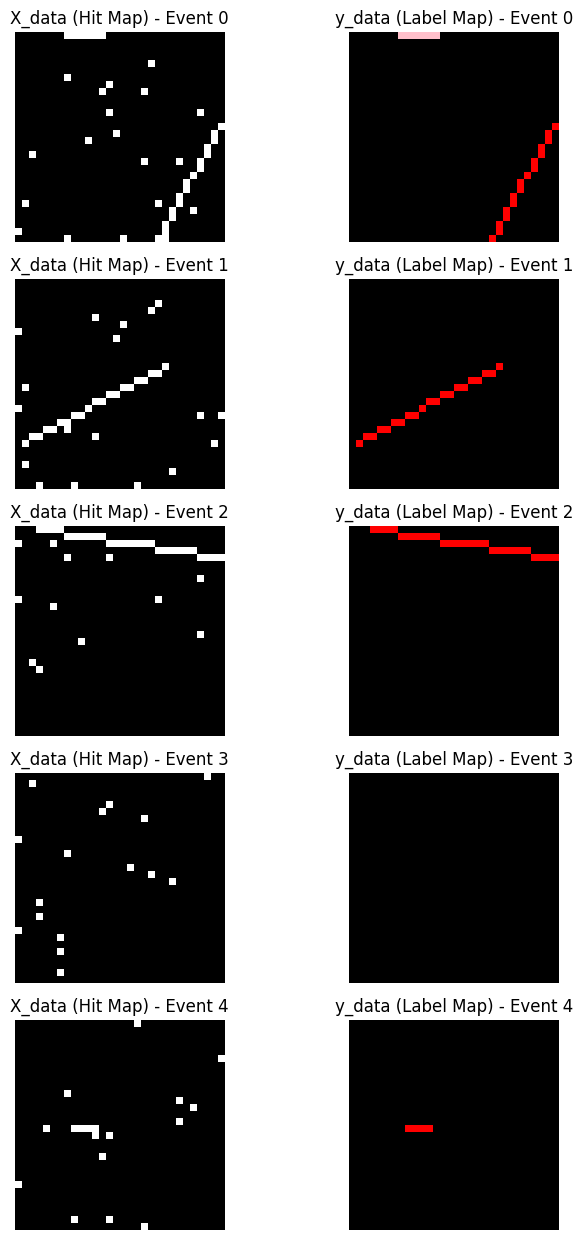

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Hit map: 0=black, 1=white
hit_cmap = ListedColormap(['black', 'white'])
label_cmap = ListedColormap(['black', 'red', 'pink'])

n_events = 5  # number of events to display

fig, axes = plt.subplots(n_events, 2, figsize=(8, 2.5 * n_events))
for i in range(n_events):
    axes[i, 0].imshow(X_data[i], cmap=hit_cmap, vmin=0, vmax=1, interpolation='none')
    axes[i, 0].set_title(f'X_data (Hit Map) - Event {i}')
    axes[i, 0].axis('off')

    label_map = np.argmax(y_data[i], axis=-1)  # shape: (30,30)
    axes[i, 1].imshow(label_map, cmap=label_cmap, vmin=0, vmax=2, interpolation='none')
    axes[i, 1].set_title(f'y_data (Label Map) - Event {i}')
    axes[i, 1].axis('off')
    
plt.tight_layout()
plt.show()

# Build model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Input(shape=(30, 30, 1)))  # Hit map

# Encoder
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))  # -> (15, 15, 64)

# Decoder
model.add(UpSampling2D(size=(2, 2)))      # -> (30, 30, 64)
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#model.add(Conv2D(3, (1, 1), padding='same', activation='softmax'))  # 3-class output
model.add(Conv2D(3, (1, 1), activation='linear', padding='same'))  # 出力層

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 up_sampling2d_2 (UpSampling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        18464     
                                                                 
 conv2d_11 (Conv2D)          (None, 30, 30, 3)        

# Do training and save the result when the "Train" flag is true
# Or it will take the previous trained result

In [18]:
from callbacks import all_callbacks
from tensorflow.keras.losses import CategoricalCrossentropy

train = True

if train:
    adam = Adam(learning_rate=0.0001)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=1e-6,
        lr_cooldown=2,
        lr_minimum=1e-7,
        outputDir='my_model_1',
    )
    history = model.fit(
        X_train,
        y_train,
        batch_size=64,
        epochs=3,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )

else:
    from tensorflow.keras.models import load_model
    model = load_model('my_model_1/KERAS_check_best_model.keras')


Epoch 1/3
94/94 [==============================] - ETA: 0s - loss: 0.2153 - accuracy: 0.9758 
***callbacks***
saving losses to my_model_1/losses.log

Epoch 1: val_loss improved from inf to 0.04694, saving model to my_model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 0.04694, saving model to my_model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to my_model_1/KERAS_check_model_last.h5

Epoch 1: saving model to my_model_1/KERAS_check_model_last_weights.h5

***callbacks end***

94/94 [==============================] - 8s 76ms/step - loss: 0.2153 - accuracy: 0.9758 - val_loss: 0.0469 - val_accuracy: 0.9807 - lr: 0.0010
Epoch 2/3
93/94 [============================>.] - ETA: 0s - loss: 0.0405 - accuracy: 0.9839
***callbacks***
saving losses to my_model_1/losses.log

Epoch 2: val_loss improved from 0.04694 to 0.03611, saving model to my_model_1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 0.04694 to 0.03611, saving model to my_model_1/KERAS_

# Process the testing sample

63/63 [==============================] - 1s 12ms/step


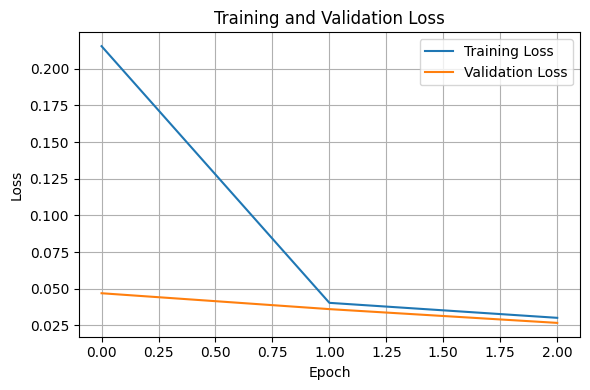

In [19]:
y_keras = model.predict(X_test)

loss = history.history['loss']
val_loss = history.history.get('val_loss')  

plt.figure(figsize=(6, 4))
plt.plot(loss, label='Training Loss')
if val_loss is not None:
    plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Check the testing result and compraing to the expected label

313/313 [==============================] - 4s 12ms/step


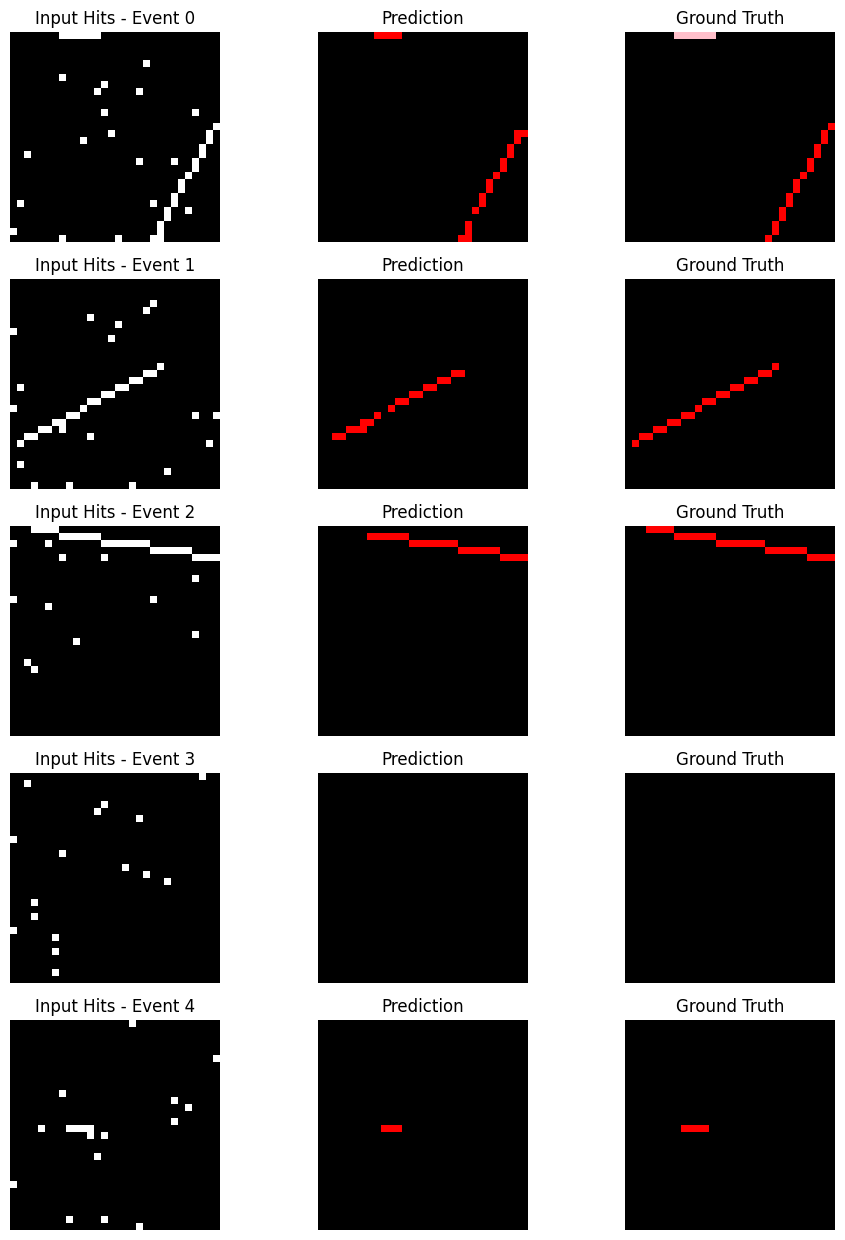

In [20]:
y_pred = model.predict(X_data)
y_pred_labels = np.argmax(y_pred, axis=-1)  # (N, 30, 30)
y_true_labels = np.argmax(y_data, axis=-1)  # (N, 30, 30)

n_events = 5
fig, axes = plt.subplots(n_events, 3, figsize=(10, 2.5 * n_events))

for i in range(n_events):
    axes[i, 0].imshow(X_data[i].squeeze(), cmap=hit_cmap, vmin=0, vmax=1, interpolation='none')
    axes[i, 0].set_title(f'Input Hits - Event {i}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(y_pred_labels[i], cmap=label_cmap, vmin=0, vmax=2, interpolation='none')
    axes[i, 1].set_title('Prediction')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(y_true_labels[i], cmap=label_cmap, vmin=0, vmax=2, interpolation='none')
    axes[i, 2].set_title('Ground Truth')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Build hls4ml model

In [21]:
import csv
import hls4ml
from hls4ml.utils import config_from_keras_model
from hls4ml.model.profiling import numerical

os.makedirs('my_model_1', exist_ok=True)

# flatten the 4D (N, 30, 30, 1) → (N, 900)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
y_keras_flat = y_keras.reshape(y_keras.shape[0], -1)
np.savetxt('my_model_1/Input.dat', X_test_flat, delimiter=' ', fmt='%.6f')
np.savetxt('my_model_1/Output.dat', y_keras_flat, delimiter=' ', fmt='%.6f')

config = config_from_keras_model(model, granularity='model')

plotting.print_dict(config)

hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir='my_model_1/hls4ml_waveform',
    part='xc7a200tsbg484-1',  # Nexys Video
    input_data_tb='my_model_1/Input.dat',
    output_data_tb='my_model_1/Output.dat',
    backend='Vitis'  
)

Interpreting Sequential
Topology:
Layer name: input_3, layer type: InputLayer, input shapes: [[None, 30, 30, 1]], output shape: [None, 30, 30, 1]
Layer name: conv2d_8, layer type: Conv2D, input shapes: [[None, 30, 30, 1]], output shape: [None, 30, 30, 32]
Layer name: conv2d_9, layer type: Conv2D, input shapes: [[None, 30, 30, 32]], output shape: [None, 30, 30, 64]
Layer name: max_pooling2d_2, layer type: MaxPooling2D, input shapes: [[None, 30, 30, 64]], output shape: [None, 15, 15, 64]
Layer name: up_sampling2d_2, layer type: UpSampling2D, input shapes: [[None, 15, 15, 64]], output shape: [None, 30, 30, 64]
Layer name: conv2d_10, layer type: Conv2D, input shapes: [[None, 30, 30, 64]], output shape: [None, 30, 30, 32]
Layer name: conv2d_11, layer type: Conv2D, input shapes: [[None, 30, 30, 32]], output shape: [None, 30, 30, 3]
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
Interpreting

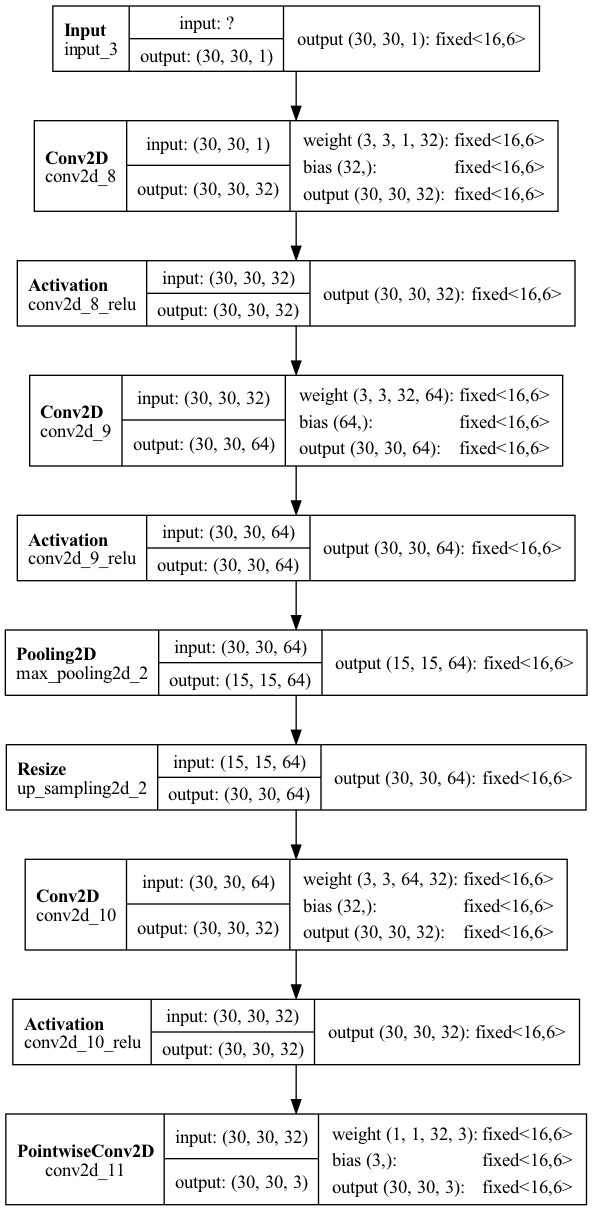

In [22]:
# This is to show the hls4ml model structure
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file='hls_model.png')
Image('hls_model.png')

In [23]:
# Compile it
hls_model.compile()

Writing HLS project
Done


In file included from firmware/myproject.cpp:3:
In file included from firmware/myproject.h:4:
In file included from firmware/ap_types/ap_fixed.h:21:
In file included from firmware/ap_types/ap_fixed_base.h:25:
In file included from firmware/ap_types/ap_int.h:319:
firmware/ap_types/ap_int_special.h:60:7: error: reference to 'complex' is ambiguous
   60 | class complex<ap_int<_AP_W> > {
      |       ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1/__fwd/complex.h:22:28: note: candidate found by name lookup is 'std::__1::complex'
   22 | class _LIBCPP_TEMPLATE_VIS complex;
      |                            ^
firmware/ap_types/ap_int_special.h:32:30: note: candidate found by name lookup is 'std::complex'
   32 | template<typename _Tp> class complex;
      |                              ^
firmware/ap_types/ap_int_special.h:193:30: error: reference to 'complex' is ambiguous
  193 | inline bool operator==(const complex<ap_int<_AP_W> > &__x, const ap_int<_AP_W> &__y) {

OSError: dlopen(my_model_1/hls4ml_waveform/firmware/myproject-4aDb8704.so, 0x0006): tried: 'my_model_1/hls4ml_waveform/firmware/myproject-4aDb8704.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSmy_model_1/hls4ml_waveform/firmware/myproject-4aDb8704.so' (no such file), '/Users/ykeisuke/opt/anaconda3/envs/hls4ml/lib/python3.10/lib-dynload/../../my_model_1/hls4ml_waveform/firmware/myproject-4aDb8704.so' (no such file), '/Users/ykeisuke/opt/anaconda3/envs/hls4ml/bin/../lib/my_model_1/hls4ml_waveform/firmware/myproject-4aDb8704.so' (no such file), '/usr/lib/my_model_1/hls4ml_waveform/firmware/myproject-4aDb8704.so' (no such file, not in dyld cache), 'my_model_1/hls4ml_waveform/firmware/myproject-4aDb8704.so' (no such file), '/Users/ykeisuke/Desktop/PHYS47X/PHYS476_keisuke/github/phys476/hls4ml/2DTrack/my_model_1/hls4ml_waveform/firmware/myproject-4aDb8704.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/ykeisuke/Desktop/PHYS47X/PHYS476_keisuke/github/phys476/hls4ml/2DTrack/my_model_1/hls4ml_waveform/firmware/myproject-4aDb8704.so' (no such file), '/Users/ykeisuke/Desktop/PHYS47X/PHYS476_keisuke/github/phys476/hls4ml/2DTrack/my_model_1/hls4ml_waveform/firmware/myproject-4aDb8704.so' (no such file)